In [6]:
import requests
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [19]:
!pip install facebook-sdk

  Using cached facebook_sdk-3.1.0-py2.py3-none-any.whl (7.5 kB)


# Dataset containg 70k news articles from huffing post, on different categories, form year 2012 to 2018, Filtered the data to only those articles which were written after 2016

In [2]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [3]:
df = df[df.date > pd.Timestamp('2016-01-01')]

In [4]:
df.shape

(70496, 6)

## The dataset contains only few features like authors, cateegory, healine, link. We will have to extract various information from the link provided for each article to see how much they were shared and Interacted with.

In [5]:
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


## Filtering data randomly to small dataset as getting Interaction info from links through fb and other platforms will take a lot of time

In [7]:
data = df.sample(frac =.25).sort_values(by='date', ascending=False).reset_index(drop=True)

In [8]:
data.shape

(17624, 6)

In [9]:
data.head()

,authors,category,date,headline,link,short_description
0,Karen Pinchin,IMPACT,2018-05-26,"With Its Way Of Life At Risk, This Remote Oyst...",https://www.huffingtonpost.com/entry/remote-oy...,The revolution is coming to rural New Brunswick.
1,Laura Bassett,POLITICS,2018-05-26,Ireland Votes To Repeal Abortion Amendment In ...,https://www.huffingtonpost.com/entry/results-f...,Irish women will no longer have to travel to t...
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ..."
3,"Michael Isikoff, Yahoo News",POLITICS,2018-05-26,'Trump's Son Should Be Concerned': FBI Obtaine...,https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...
4,Kenya Downs,BLACK VOICES,2018-05-25,"In Historic Victory, Barbados Elects First Fem...",https://www.huffingtonpost.com/entry/mia-victo...,Mia Amor Mottley even earned the backing of th...


### Saving the file for future use

In [13]:
data.to_csv('final.csv')

## Extracting engagement info for each and every link, how many times they have been shared, interacted with, commented on.

## These values will then be used to identify whether to classify a news article as viral or not(assumption based)

In [60]:
import facebook
graph = facebook.Graph`API(access_token="EAAVIco8eK1sBAMzxTrVOG4oOW5fh3QLyAszKzDZBgUoujZCcpAJO0a3XqidZCy2coCZBhJta3yknKAdobx5RlNSPT64HC2d3Cos4AKjJii3CAaENgulsC01D0Oel3f1askbd13ZAT4n0gZBeKJ1FfWxpgZBr9sNUk8ZCQnYqP28516TYcaKw5drzQYcSTZBOCI2Wtfgr5Us206SgVp4gRrAEND6YaohX3WnW0bmiVU3rnlwZDZD", version="3.1")

### As only 200 api call are possible in an hour from an access token, so to speed things up i created 3 apps on fb to get 3 different access tokens for each hour.
### TO further speed things up instea of calling one link at a time i was passing 15(max allowed is 20) in the get_objects call.

In [17]:
x = list(range(0, data.shape[0], 15))
y = x[::190]

In [18]:
y = y[1:]
y

[2850, 5700, 8550, 11400, 14250, 17100]

In [15]:
def social_count(x, Interactions):
    shr = graph.get_objects(ids=list(x.values), fields='engagement')
    for link in shr:
        Interactions.append(shr[link]['engagement']['share_count']+shr[link]['engagement']['reaction_count']+shr[link]['engagement']['comment_count'])

In [16]:
Interactions = []

In [62]:
for i in range(11400, 14250, 15):
    social_count(data.link[i:i+15], Interactions)

In [63]:
len(Interactions)

14250

## Saving the extracted information into the txt file, as if the kernel stops we will have to make the calls again and again for the same info(happened a lot with me)

In [70]:
with open('s.txt','w' ) as file1:
    for line in Interactions:
        print(line, file=file1)

In [65]:
df = data.iloc[:len(Interactions), :]
df.shape

(14250, 6)

## ADDING INTERACTION COLUMNS TO THE DATA SET

In [66]:
df['Interactions'] = pd.Series(Interactions)

In [33]:
df.head()

,authors,category,date,headline,link,short_description,Interactions
0,Karen Pinchin,IMPACT,2018-05-26,"With Its Way Of Life At Risk, This Remote Oyst...",https://www.huffingtonpost.com/entry/remote-oy...,The revolution is coming to rural New Brunswick.,113
1,Laura Bassett,POLITICS,2018-05-26,Ireland Votes To Repeal Abortion Amendment In ...,https://www.huffingtonpost.com/entry/results-f...,Irish women will no longer have to travel to t...,11046
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",8066
3,"Michael Isikoff, Yahoo News",POLITICS,2018-05-26,'Trump's Son Should Be Concerned': FBI Obtaine...,https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,14120
4,Kenya Downs,BLACK VOICES,2018-05-25,"In Historic Victory, Barbados Elects First Fem...",https://www.huffingtonpost.com/entry/mia-victo...,Mia Amor Mottley even earned the backing of th...,15282


## Selecting only those tuples which have more than 500 interactions(Assumption based)

In [136]:
w = df[df.Interactions > 500]

In [129]:
workset.shape

(2492, 8)

In [66]:
data.head()

,index,authors,category,date,headline,link,short_description,Shares
0,12,Karen Pinchin,IMPACT,2018-05-26,"With Its Way Of Life At Risk, This Remote Oyst...",https://www.huffingtonpost.com/entry/remote-oy...,The revolution is coming to rural New Brunswick.,63
1,10,Sebastian Murdock,ENTERTAINMENT,2018-05-26,Justin Timberlake Visits Texas School Shooting...,https://www.huffingtonpost.com/entry/justin-ti...,"The pop star also wore a ""Santa Fe Strong"" shi...",94
2,18,Chris D'Angelo,POLITICS,2018-05-26,Ryan Zinke Looks To Reel Back Some Critics Wit...,https://www.huffingtonpost.com/entry/ryan-zink...,The interior secretary attempts damage control...,142
3,22,Hilary Hanson,WEIRD NEWS,2018-05-26,Mystery 'Wolf-Like' Animal Reportedly Shot In ...,https://www.huffingtonpost.com/entry/montana-w...,“We have no idea what this was until we get a ...,410
4,38,Ron Dicker,COMEDY,2018-05-25,Seth Meyers Has 1 Funny Regret After Trump Can...,https://www.huffingtonpost.com/entry/seth-meye...,There goes the one token of his appreciation.,78


In [55]:
!pip install urllib2

ERROR: Could not find a version that satisfies the requirement urllib2 (from versions: none)
ERROR: No matching distribution found for urllib2


# EXRACTING THE NUMBER OF IMAGES IN EACH ARTICLE TO SEE IF THERE'S ANY REALTION BETWEEN NUMBER OF IMAGES AND ARTICLE INTERACTION

In [78]:
import urllib

import bs4  # beautifulsoup4
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
def get_image_count(site):
    try: 
        req = urllib.request.Request(site, headers=hdr)
        html = urllib.request.urlopen(req).read()
        soup = bs4.BeautifulSoup(html)
        images = soup.findAll('img')
        print("link done", end=" ")
        return len(images)
    except:
        return 0

In [79]:
workset['img_count'] = workset['link'].apply(get_image_count)

nelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink donelink don

In [80]:
workset.to_csv('workset.csv')

In [7]:
workset = pd.read_csv('workset.csv')

In [8]:
ind = workset[workset.img_count==0].index

In [9]:
workset.drop(index=ind, inplace=True)

In [137]:
## WE CAN SEE THAT THERE'S A SWEET SPOT WHERE THE NUMBER OF ARTILES SHARED INCREASES IMMENSLY WITH NUMBER OF IMAGES AND THEN IF THERE ARE TOO MANY IMAGES IT DEACREASES.

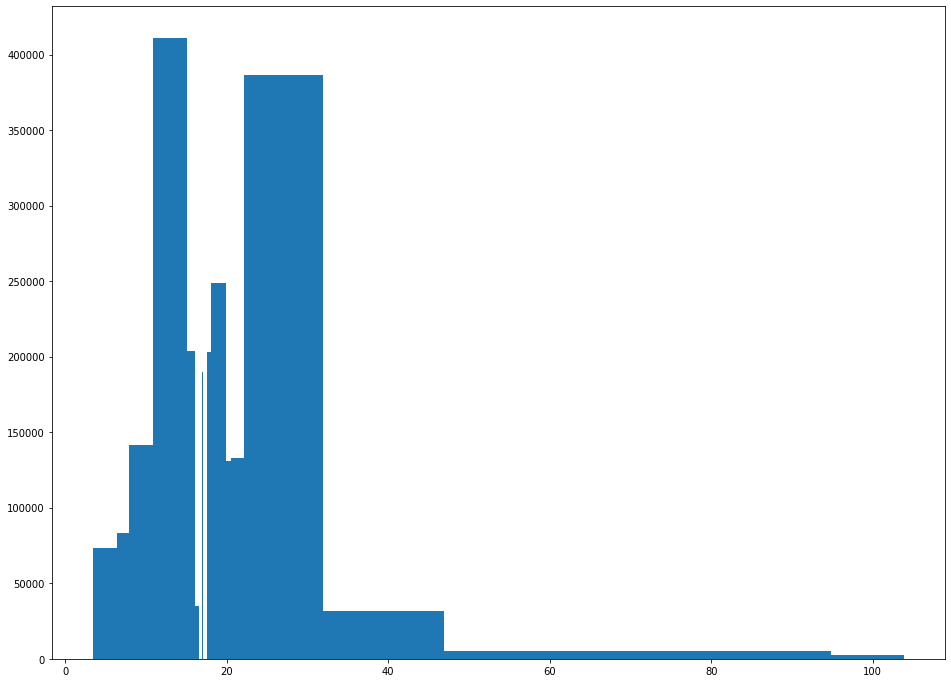

In [94]:
plt.figure(figsize=(16, 12))
plt.bar(workset.img_count, workset.Interactions)
plt.show()

## I created a function that takes in a Series, an integer, and a Boolean value. The integer determines the n we'll use for n-gram parsing, while the Boolean determines whether we exclude stop words. The function returns the number of tuples per row and the frequency for each tuple.
## Through this We can start to see some of the components of the headlines that we see over and over again.

In [141]:
from nltk.util import ngrams 
from nltk.corpus import stopwords 
import re
def get_word_stats(txt_series, n, rem_stops=False): 
    txt_words = [] 
    txt_len = []
    for w in txt_series:
        if w is not None:
            if rem_stops == False: 
                word_list = [x for x in ngrams(re.findall(r"[a-z0-9']+", w.lower()), n)]
            else:
                word_list = [y for y in ngrams([x for x in re.findall(r"[a-z0-9']+", w.lower())\
                if x not in stopwords.words('english')], n)]               
            word_list_len = len(list(word_list)) 
            txt_words.extend(word_list) 
            txt_len.append(word_list_len)
    return pd.Series(txt_words).value_counts().to_frame('count'), pd.DataFrame(txt_len, columns=['count'])


In [142]:
hw, hl = get_word_stats(workset.headline, 3, 1)

In [144]:
hw.head(50)

,count
"(tweets, women, week)",8
"(sexual, misconduct, allegations)",8
"(funniest, tweets, women)",8
"(20, funniest, tweets)",8
"(gop, tax, bill)",7
"(sarah, huckabee, sanders)",6
"(donald, trump, jr)",4
"(iran, nuclear, deal)",4
"(kim, jong, un)",4
"(white, house, official)",4


### Determing how to classify the news as viral or not

In [147]:
print(workset.Interactions.quantile(0.10))
print(workset.Interactions.quantile(0.25))
print(workset.Interactions.quantile(0.50))
print(workset.Interactions.quantile(0.75))

712.0
1174.0
2805.5
7552.0


### AS WE HAVE ALREADY LEFT ALL THE INTERACTION LESS THAN 500 WHILE CREATING FINAL DATASET SO MORE THAN 4000 INTERACTION  SEEMS LIKE A SWEET SPOT

In [197]:
def categorizer(x):
    if x>4000:
        return 1
    else:
        return 0

In [198]:
workset['Viral'] = workset.Interactions.apply(categorizer)

In [199]:
workset.head()

,Unnamed: 0,authors,category,date,headline,link,short_description,Interactions,img_count,Viral,text
0,1,Laura Bassett,POLITICS,2018-05-26,Ireland Votes To Repeal Abortion Amendment In ...,https://www.huffingtonpost.com/entry/results-f...,Irish women will no longer have to travel to t...,11046,18,1,0
1,2,Ron Dicker,ENTERTAINMENT,2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",8066,20,1,0
2,3,"Michael Isikoff, Yahoo News",POLITICS,2018-05-26,'Trump's Son Should Be Concerned': FBI Obtaine...,https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,14120,11,1,0
3,4,Kenya Downs,BLACK VOICES,2018-05-25,"In Historic Victory, Barbados Elects First Fem...",https://www.huffingtonpost.com/entry/mia-victo...,Mia Amor Mottley even earned the backing of th...,15282,23,1,0
4,5,Elyse Wanshel,ENTERTAINMENT,2018-05-25,David Cross Proves Yet Again That He’s Terribl...,https://www.huffingtonpost.com/entry/david-cro...,The comedian suggested Jessica Walter was also...,511,19,0,0


## (NOT USED WAS TAKING A LOT OF TIME AND CALL) EXTRACTING THE NUMBER OF WORD IN EACH ARTICLE

In [200]:
## NOT USED
def get_text_count(site):
    try: 
        req = urllib.request.Request(site, headers=hdr)
        html = urllib.request.urlopen(req).read()
        soup = bs4.BeautifulSoup(html, 'lxml')
        txt = soup.get_text()
        print(tx[:5], end=" ")
        return txt
    except:
        return 0

In [201]:
## NOT USED
workset['text'] = workset['link'].apply(get_text_count)

In [202]:
workset.dropna(subset=['short_description'], inplace=True)

### Train

In [203]:
from sklearn.feature_extraction.text import CountVectorizer
## Creating count vectorizer for headlines and short description
vect = CountVectorizer(min_df=5, ngram_range=(2, 2))
hed = vect.fit(workset.headline).transform(workset.headline)
des = vect.fit(workset.short_description).transform(workset.short_description)

## Dummy variable creation
ctg = pd.get_dummies(workset['category'], drop_first=True)

## Assembling all the numerical values in the data
num_values = pd.merge(ctg, workset.img_count, left_index=True, right_index=True).values

##  Putting them all into a scipy sparse matrix as count vectorizer return a sparse matrix
data_features = sparse.hstack((hed, des, num_values))
data_catg = workset.Viral

## SPLITTING OF DATASET

In [204]:
features = data_features.toarray()

In [205]:
X = features
y = data_catg.values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# MODEL CREATION

## Please keep in mind we haven't added the numbe rof text in each article column, as it took too long to extract and kernal kept crashing.
## The model would would have taken yearwise data and added other parametrs like, colour schemas of the page

## We can other models like predricitng how many interactions the page will have 


In [206]:
import xgboost as xgb


In [207]:
params = {
    'eta': 0.3,
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'max_depth': 30, 
    'min_child_weight':15,
    'subsample': 0.9, 
    'alpha':1,
    'objective': 'binary:logistic', 
    'scale_pos_weight':100,
    'eval_metric': 'auc', 
    'nthread':4,
    'silent': 1
}

In [208]:
dmtrain = xgb.DMatrix(X_train, label= y_train)
demtest = xgb.DMatrix(X_test, label=y_test)


In [209]:
watchlist = [(dmtrain, 'train'), (demtest, 'test')]
model = xgb.train(params, dmtrain, 50, watchlist, maximize=True, early_stopping_rounds=10, verbose_eval=1)

[0]	train-auc:0.5	test-auc:0.5
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 10 rounds.
[1]	train-auc:0.504249	test-auc:0.49773
[2]	train-auc:0.509926	test-auc:0.499348
[3]	train-auc:0.511591	test-auc:0.499925
[4]	train-auc:0.515826	test-auc:0.507506
[5]	train-auc:0.544901	test-auc:0.489116
[6]	train-auc:0.556453	test-auc:0.494468
[7]	train-auc:0.582741	test-auc:0.512926
[8]	train-auc:0.588057	test-auc:0.5133
[9]	train-auc:0.615075	test-auc:0.528435
[10]	train-auc:0.621721	test-auc:0.523042
[11]	train-auc:0.63105	test-auc:0.52808
[12]	train-auc:0.634257	test-auc:0.522465
[13]	train-auc:0.63969	test-auc:0.522031
[14]	train-auc:0.648787	test-auc:0.524274
[15]	train-auc:0.658745	test-auc:0.533031
[16]	train-auc:0.659504	test-auc:0.540585
[17]	train-auc:0.66222	test-auc:0.545631
[18]	train-auc:0.665244	test-auc:0.547211
[19]	train-auc:0.667704	test-auc:0.544488
[20]	train-auc:0.668174	test-auc:0.540844
[21]

In [167]:
def best_params(train_x, train_y):
    rfc = RandomForestClassifier()
    param_grid = { 
        'n_estimators': [50, 400],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(train_x, train_y)
    return CV_rfc.best_params_

print(best_params(X_train, y_train))

{'max_features': 'auto', 'n_estimators': 50}


In [210]:
rf = RandomForestClassifier(n_estimators=50, max_features='auto').fit(X_train, y_train)
print('Cross Validation for RandomForestClassifier')
print(rf.score(X_test, y_test))

Cross Validation for RandomForestClassifier
0.5207496653279786
